In [124]:
import time,json,os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.ensemble import BaggingClassifier
from common import preprocess
import seaborn as sns
from sklearn.svm import SVC
import joblib
from warnings import filterwarnings
filterwarnings("ignore") 
np.set_printoptions(suppress=True)
pd.set_option('display.float_format',lambda x : '%.4f' % x)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
plt.style.use({'figure.figsize':(12, 4)})

In [125]:
def show_heatmap(df):
    plt.style.use({'figure.figsize':(12, 6)})
    plt.ticklabel_format(style='plain',axis='both')
    cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)
    return sns.heatmap(df, cmap = cmap, linewidths = 0.05,annot=False, fmt="g",annot_kws={"fontsize":16})
    #plt.xticks(rotation=60)
    #plt.yticks(rotation=60)

In [126]:
class CJAnalyse:
    
    def __init__(self, model_name):
        self.df_similarity = pd.read_csv("/data/paper/analyse/similarity.csv",index_col=0)
        self.df_model = pd.read_csv("/data/paper/analyse/%s.csv"%model_name,index_col=0)
        self.filter_useless_fields()
        
    def get_similar(self, d1, d2):
        mask = (self.df_similarity['D1'] == "%s"%d1) & (self.df_similarity['D2'] == d2)
        ret = {}
        for D in self.df_similarity.keys():
            if D in ['D1','D2']:
                continue
            ret[D] = self.df_similarity[mask].iloc[0][D]
        return ret
    
    def filter_useless_fields(self):
        df_m = self.df_model.copy( deep = True )
        del df_m['confusion_matrix']
        del df_m['roc_curve']
        del df_m['mcc']
        del df_m['log_loss']
        del df_m['fbeta_score']
        self.df_model = df_m
        
    def Merge(self):
        all_data = []
        for item in json.loads(self.df_model.to_json(orient="records")):
            tmp = item
            tmp["train"] = item["train"]
            tmp["valid"] = item["valid"]
            similar = self.get_similar(item["train"], item['valid'])
            for s in similar:
                tmp[s] = similar[s]
            all_data.append(tmp)
        return pd.DataFrame(all_data)
    
    #pearsonr,spearmanr or kendalltau
    def Correlation(self,df, kind = "pearsonr"):
        df_merged = df.copy( deep= True )
        all_data = []
        for score in self.df_model.keys():
            if score in ['model', 'train', 'valid']:
                continue
            s1 = df_merged[score]
            metric_value = {}
            metric_value['score'] = score
            metric_list = self.df_similarity.keys()
            for metric in metric_list:
                if metric in ['D1','D2']:
                    continue
                s2 = df_merged[metric]
                if kind == 'pearsonr':
                    metric_value[metric] = scipy.stats.pearsonr(s1,s2)[0]
                if kind == 'spearmanr':
                    metric_value[metric] = scipy.stats.spearmanr(s1,s2)[0]
                if kind == 'kendalltau':
                    metric_value[metric] = scipy.stats.kendalltau(s1,s2)[0]
                metric_value[metric] = abs(metric_value[metric])
            all_data.append(metric_value)

        df_all = pd.DataFrame(all_data)
        df_all.set_index("score", inplace = True, drop = True)
        return df_all #.reset_index()

In [127]:
test = CJAnalyse("cnn")
df_all = test.Merge()

# Correlations for each base set

In [128]:
df_base_set_corr = pd.DataFrame()
for train_set in ["s-0-*","s-1-*","s-2-*","s-3-*"]:
    mask = df_all.train.str.contains(r'%s'%train_set)
    df_test = df_all[mask]
    df_base_set_corr[train_set] = test.Correlation(df_test).mean()
display(df_base_set_corr.T.mean())
df_base_set_corr

Cosine      0.6627
Pearson     0.6627
Euclidean   0.6905
EDM         0.7765
KS          0.5644
Manhattan   0.7364
Minkowski   0.6563
Jaccard     0.1572
dtype: float64

,s-0-*,s-1-*,s-2-*,s-3-*
Cosine,0.5718,0.6541,0.7252,0.6998
Pearson,0.5715,0.6538,0.7256,0.7000
Euclidean,0.6940,0.6494,0.7153,0.7032
EDM,0.8294,0.6319,0.8724,0.7722
KS,0.6953,0.3740,0.5798,0.6087
Manhattan,0.6552,0.6391,0.8552,0.7959
Minkowski,0.7236,0.6115,0.6389,0.6509
Jaccard,0.1875,0.1863,0.1210,0.1340


Text(0.5, 1.0, 'Correlation between Base sample and Distance')

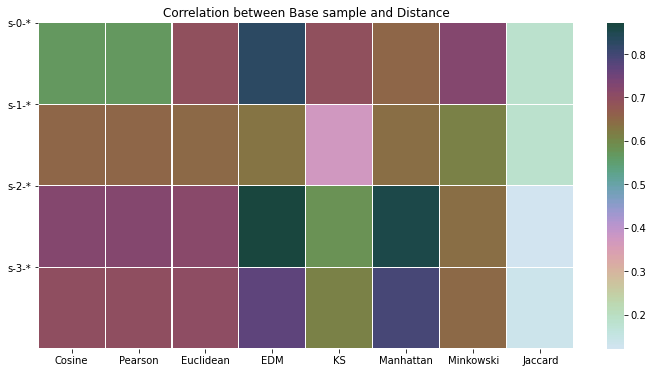

In [129]:
ax = show_heatmap(df_base_set_corr.T)
ticks = ax.set_yticks(range(len(df_base_set_corr.T.index))) # 设置刻度
labels = ax.set_yticklabels(df_base_set_corr.T.index,rotation = 0 ) # 设置刻度标签
ax.set_title("Correlation between Base sample and Distance")

Text(0.5, 1.0, 'Correlation between Base sample and Distance')

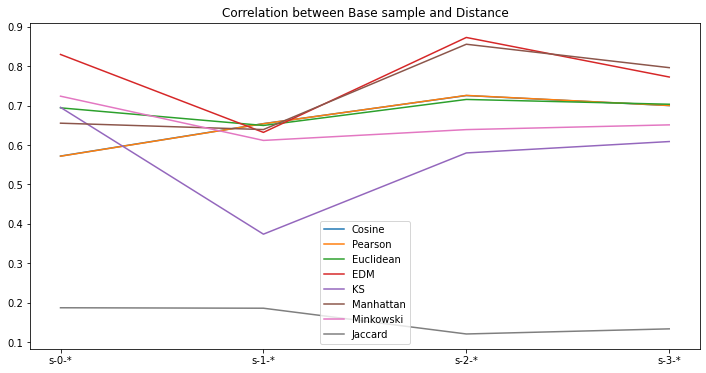

In [130]:
ax = df_base_set_corr.T.plot(kind='line')
ticks = ax.set_xticks(range(len(df_base_set_corr.T.index))) # 设置刻度
labels = ax.set_xticklabels(df_base_set_corr.T.index,rotation = 0 ) # 设置刻度标签
ax.set_title("Correlation between Base sample and Distance")

# Correlations for each train set

In [131]:
df_group = df_all.groupby("train")
df_train_set_corr = pd.DataFrame()
for train_set,df in df_group:    
    df_train_set_corr[train_set] = test.Correlation(df).mean()
print("Total mean correlation")
display(df_train_set_corr.T.mean())
df_train_set_corr.T

Total mean correlation


Cosine      0.6895
Pearson     0.6895
Euclidean   0.7173
EDM         0.8109
KS          0.5964
Manhattan   0.7604
Minkowski   0.6842
Jaccard     0.1697
dtype: float64

,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
s-0-1-0,0.5578,0.5573,0.6943,0.8667,0.7092,0.6450,0.7315,0.1862
s-0-2-0,0.6403,0.6398,0.7679,0.8896,0.7649,0.7241,0.8001,0.1930
s-0-3-0,0.6180,0.6179,0.7074,0.7461,0.7012,0.6641,0.7362,0.2134
s-0-4-0,0.6056,0.6054,0.7395,0.8575,0.7484,0.6849,0.7806,0.2187
s-1-1-0,0.6774,0.6772,0.6757,0.6993,0.4007,0.6798,0.6414,0.2200
s-1-2-0,0.5031,0.5026,0.5102,0.5443,0.3498,0.4813,0.4803,0.2073
s-1-3-0,0.8259,0.8257,0.8132,0.8281,0.4515,0.8203,0.7585,0.1917
s-1-4-0,0.7742,0.7739,0.7820,0.8190,0.4893,0.7615,0.7500,0.2177
s-2-1-0,0.7257,0.7260,0.7208,0.8662,0.5546,0.8439,0.6512,0.1219
s-2-2-0,0.7379,0.7382,0.7267,0.8902,0.5657,0.8742,0.6468,0.1210


Text(0.5, 1.0, 'Correlation between Train sample and Distance')

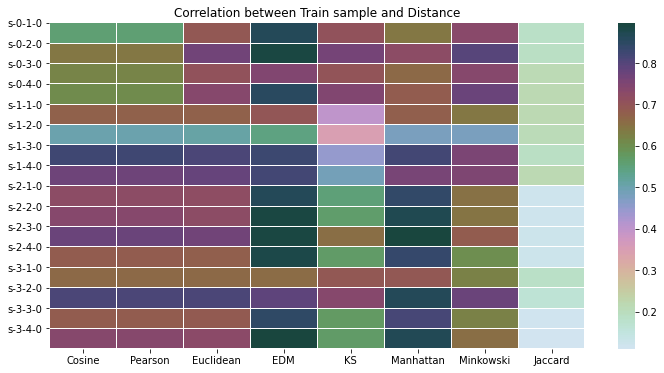

In [132]:
ax = show_heatmap(df_train_set_corr.T)
ticks = ax.set_yticks(range(len(df_train_set_corr.T.index))) # 设置刻度
labels = ax.set_yticklabels(df_train_set_corr.T.index,rotation = 0 ) # 设置刻度标签
ax.set_title("Correlation between Train sample and Distance")

Text(0.5, 1.0, 'Correlation between Train Dataset and Distance')

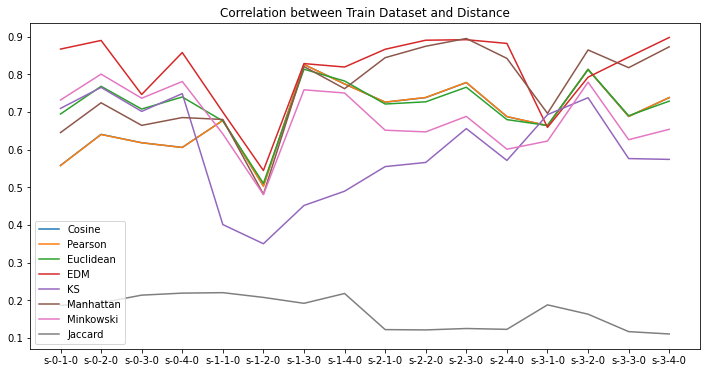

In [133]:
ax = df_train_set_corr.T.plot(kind='line')
ticks = ax.set_xticks(range(len(df_train_set_corr.T.index))) # 设置刻度
labels = ax.set_xticklabels(df_train_set_corr.T.index,rotation = 0 ) # 设置刻度标签
ax.set_title("Correlation between Train Dataset and Distance")

# Detail correlation for each train set

In [134]:
df_group = df_all.groupby("train")
for train_set, df in df_group:
    mask = (df_all.train == train_set)
    df_test = df_all[mask]
    corr = test.Correlation(df_test)
    print("Mean correlation for train set ", train_set)
    display ( corr.mean() )

Mean correlation for train set  s-0-1-0


Cosine      0.5578
Pearson     0.5573
Euclidean   0.6943
EDM         0.8667
KS          0.7092
Manhattan   0.6450
Minkowski   0.7315
Jaccard     0.1862
dtype: float64

Mean correlation for train set  s-0-2-0


Cosine      0.6403
Pearson     0.6398
Euclidean   0.7679
EDM         0.8896
KS          0.7649
Manhattan   0.7241
Minkowski   0.8001
Jaccard     0.1930
dtype: float64

Mean correlation for train set  s-0-3-0


Cosine      0.6180
Pearson     0.6179
Euclidean   0.7074
EDM         0.7461
KS          0.7012
Manhattan   0.6641
Minkowski   0.7362
Jaccard     0.2134
dtype: float64

Mean correlation for train set  s-0-4-0


Cosine      0.6056
Pearson     0.6054
Euclidean   0.7395
EDM         0.8575
KS          0.7484
Manhattan   0.6849
Minkowski   0.7806
Jaccard     0.2187
dtype: float64

Mean correlation for train set  s-1-1-0


Cosine      0.6774
Pearson     0.6772
Euclidean   0.6757
EDM         0.6993
KS          0.4007
Manhattan   0.6798
Minkowski   0.6414
Jaccard     0.2200
dtype: float64

Mean correlation for train set  s-1-2-0


Cosine      0.5031
Pearson     0.5026
Euclidean   0.5102
EDM         0.5443
KS          0.3498
Manhattan   0.4813
Minkowski   0.4803
Jaccard     0.2073
dtype: float64

Mean correlation for train set  s-1-3-0


Cosine      0.8259
Pearson     0.8257
Euclidean   0.8132
EDM         0.8281
KS          0.4515
Manhattan   0.8203
Minkowski   0.7585
Jaccard     0.1917
dtype: float64

Mean correlation for train set  s-1-4-0


Cosine      0.7742
Pearson     0.7739
Euclidean   0.7820
EDM         0.8190
KS          0.4893
Manhattan   0.7615
Minkowski   0.7500
Jaccard     0.2177
dtype: float64

Mean correlation for train set  s-2-1-0


Cosine      0.7257
Pearson     0.7260
Euclidean   0.7208
EDM         0.8662
KS          0.5546
Manhattan   0.8439
Minkowski   0.6512
Jaccard     0.1219
dtype: float64

Mean correlation for train set  s-2-2-0


Cosine      0.7379
Pearson     0.7382
Euclidean   0.7267
EDM         0.8902
KS          0.5657
Manhattan   0.8742
Minkowski   0.6468
Jaccard     0.1210
dtype: float64

Mean correlation for train set  s-2-3-0


Cosine      0.7778
Pearson     0.7781
Euclidean   0.7654
EDM         0.8916
KS          0.6556
Manhattan   0.8948
Minkowski   0.6880
Jaccard     0.1248
dtype: float64

Mean correlation for train set  s-2-4-0


Cosine      0.6872
Pearson     0.6876
Euclidean   0.6794
EDM         0.8817
KS          0.5710
Manhattan   0.8420
Minkowski   0.6008
Jaccard     0.1226
dtype: float64

Mean correlation for train set  s-3-1-0


Cosine      0.6634
Pearson     0.6634
Euclidean   0.6638
EDM         0.6587
KS          0.6926
Manhattan   0.6960
Minkowski   0.6224
Jaccard     0.1876
dtype: float64

Mean correlation for train set  s-3-2-0


Cosine      0.8125
Pearson     0.8126
Euclidean   0.8127
EDM         0.7921
KS          0.7375
Manhattan   0.8644
Minkowski   0.7788
Jaccard     0.1628
dtype: float64

Mean correlation for train set  s-3-3-0


Cosine      0.6877
Pearson     0.6880
Euclidean   0.6897
EDM         0.8453
KS          0.5759
Manhattan   0.8173
Minkowski   0.6261
Jaccard     0.1165
dtype: float64

Mean correlation for train set  s-3-4-0


Cosine      0.7378
Pearson     0.7381
Euclidean   0.7285
EDM         0.8975
KS          0.5738
Manhattan   0.8727
Minkowski   0.6537
Jaccard     0.1103
dtype: float64

In [135]:
df_group = df_all.groupby("train")
for train_set, df in df_group:
    mask = (df_all.train == train_set)
    df_test = df_all[mask]
    corr = test.Correlation(df_test)
    print("Detail correlation for train set ", train_set)
    display ( corr )

Detail correlation for train set  s-0-1-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.4861,0.4855,0.6597,0.9393,0.7382,0.5951,0.7108,0.1992
accuracy,0.6941,0.6937,0.8191,0.9061,0.7716,0.7800,0.8487,0.2132
precision,0.2844,0.2837,0.4624,0.8113,0.5358,0.3925,0.5193,0.1406
auc,0.9622,0.9620,0.9908,0.8029,0.8824,0.9880,0.9838,0.2142
f1_score,0.3622,0.3616,0.5393,0.8738,0.6181,0.4694,0.5947,0.1640


Detail correlation for train set  s-0-2-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.6898,0.6893,0.8264,0.9528,0.8282,0.7802,0.8606,0.2119
accuracy,0.8226,0.8223,0.9174,0.8970,0.8495,0.8916,0.9342,0.2187
precision,0.2695,0.2688,0.4529,0.8117,0.5352,0.3818,0.5115,0.1372
auc,0.9166,0.9163,0.9753,0.8625,0.8944,0.9612,0.9790,0.2162
f1_score,0.5029,0.5023,0.6674,0.9239,0.7172,0.6056,0.7154,0.1811


Detail correlation for train set  s-0-3-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.9176,0.9176,0.8802,0.4270,0.7309,0.8986,0.8510,0.1803
accuracy,0.8573,0.8570,0.9460,0.8343,0.9098,0.9121,0.9643,0.2480
precision,0.0330,0.0335,0.1826,0.7943,0.3237,0.0846,0.2661,0.1660
auc,0.8729,0.8727,0.9509,0.7552,0.8856,0.9288,0.9626,0.2418
f1_score,0.4093,0.4088,0.5773,0.9198,0.6563,0.4963,0.6368,0.2307


Detail correlation for train set  s-0-4-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.8808,0.8806,0.9610,0.7888,0.8899,0.9377,0.9728,0.2196
accuracy,0.8528,0.8525,0.9518,0.8436,0.8993,0.9188,0.9722,0.2412
precision,0.0152,0.0158,0.2082,0.8217,0.3502,0.1088,0.2936,0.1645
auc,0.8158,0.8155,0.9290,0.8677,0.8823,0.8910,0.9547,0.2386
f1_score,0.4632,0.4627,0.6477,0.9657,0.7204,0.5680,0.7095,0.2297


Detail correlation for train set  s-1-1-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.9032,0.9033,0.8486,0.8603,0.2154,0.9239,0.7757,0.1525
accuracy,0.6742,0.6737,0.7069,0.6677,0.5370,0.6496,0.6939,0.2727
precision,0.7114,0.7110,0.7406,0.7408,0.5042,0.6872,0.7223,0.2523
auc,0.3608,0.3609,0.3317,0.4738,0.3066,0.4191,0.2927,0.1995
f1_score,0.7375,0.7371,0.7507,0.7541,0.4401,0.7193,0.7222,0.2227


Detail correlation for train set  s-1-2-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.4541,0.4534,0.4611,0.3917,0.3028,0.4061,0.4365,0.1668
accuracy,0.6295,0.6289,0.6405,0.6783,0.4394,0.5987,0.6046,0.2559
precision,0.6810,0.6805,0.6875,0.7322,0.4100,0.6468,0.6439,0.2441
auc,0.0992,0.0992,0.1081,0.2209,0.2322,0.1365,0.1085,0.1544
f1_score,0.6517,0.6512,0.6540,0.6984,0.3648,0.6185,0.6081,0.2155


Detail correlation for train set  s-1-3-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.9328,0.9331,0.8596,0.7144,0.4246,0.9541,0.7626,0.0988
accuracy,0.7634,0.7629,0.7738,0.7744,0.4334,0.7393,0.7414,0.2348
precision,0.6375,0.6370,0.6640,0.8711,0.3748,0.6194,0.6384,0.1944
auc,0.9420,0.9419,0.9318,0.8780,0.5576,0.9379,0.8760,0.2563
f1_score,0.8538,0.8536,0.8366,0.9028,0.4670,0.8505,0.7743,0.1740


Detail correlation for train set  s-1-4-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.9291,0.9294,0.8475,0.7010,0.4055,0.9546,0.7555,0.0911
accuracy,0.6860,0.6854,0.7285,0.7648,0.4635,0.6481,0.7240,0.2367
precision,0.5918,0.5913,0.6432,0.8531,0.4250,0.5619,0.6409,0.2122
auc,0.8763,0.8761,0.8987,0.8862,0.6787,0.8681,0.8763,0.3642
f1_score,0.7877,0.7873,0.7919,0.8901,0.4738,0.7749,0.7535,0.1845


Detail correlation for train set  s-2-1-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.7654,0.7658,0.7443,0.9587,0.5555,0.9244,0.6567,0.1118
accuracy,0.8075,0.8076,0.8112,0.7657,0.6585,0.8525,0.7525,0.1416
precision,0.4570,0.4575,0.4676,0.8243,0.2722,0.6517,0.4136,0.0996
auc,0.9255,0.9256,0.9166,0.8371,0.8232,0.9328,0.8467,0.1427
f1_score,0.6729,0.6733,0.6642,0.9451,0.4639,0.8579,0.5867,0.1135


Detail correlation for train set  s-2-2-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.7527,0.7531,0.7320,0.9527,0.5892,0.9198,0.6445,0.0993
accuracy,0.8421,0.8423,0.8335,0.7704,0.6593,0.8828,0.7634,0.1480
precision,0.5202,0.5207,0.5190,0.9115,0.3375,0.7551,0.4395,0.1070
auc,0.9179,0.9180,0.9050,0.8695,0.7580,0.9540,0.8290,0.1435
f1_score,0.6564,0.6569,0.6439,0.9471,0.4845,0.8594,0.5578,0.1074


Detail correlation for train set  s-2-3-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.7743,0.7747,0.7529,0.9541,0.6227,0.9280,0.6643,0.1110
accuracy,0.8568,0.8569,0.8496,0.7547,0.7830,0.8827,0.7840,0.1392
precision,0.6129,0.6134,0.6099,0.9162,0.4470,0.8047,0.5382,0.1158
auc,0.9260,0.9262,0.9099,0.8813,0.8658,0.9658,0.8319,0.1430
f1_score,0.7191,0.7196,0.7046,0.9516,0.5594,0.8929,0.6214,0.1149


Detail correlation for train set  s-2-4-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.7022,0.7026,0.6857,0.9459,0.5899,0.8880,0.6005,0.0917
accuracy,0.7217,0.7219,0.7233,0.7644,0.5699,0.8138,0.6557,0.1470
precision,0.4978,0.4983,0.4963,0.8958,0.4140,0.7365,0.4173,0.1171
auc,0.9064,0.9066,0.8933,0.8696,0.7676,0.9473,0.8166,0.1489
f1_score,0.6079,0.6083,0.5982,0.9328,0.5135,0.8243,0.5141,0.1082


Detail correlation for train set  s-3-1-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.8195,0.8197,0.8428,0.8947,0.8474,0.9378,0.7855,0.1863
accuracy,0.7865,0.7863,0.7686,0.2800,0.7929,0.6566,0.7494,0.2004
precision,0.1193,0.1191,0.0413,0.3004,0.2100,0.0309,0.0019,0.1179
auc,0.8219,0.8220,0.8599,0.8750,0.8217,0.9279,0.8182,0.2471
f1_score,0.7697,0.7699,0.8066,0.9436,0.7910,0.9269,0.7570,0.1864


Detail correlation for train set  s-3-2-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.8705,0.8706,0.8723,0.9027,0.8066,0.9462,0.8332,0.1954
accuracy,0.7669,0.7666,0.7523,0.3206,0.7590,0.6528,0.7377,0.1728
precision,0.6448,0.6452,0.6563,0.9331,0.5135,0.8039,0.6179,0.0847
auc,0.9185,0.9186,0.9215,0.8738,0.8291,0.9670,0.8854,0.1983
f1_score,0.8620,0.8622,0.8613,0.9302,0.7795,0.9519,0.8201,0.1628


Detail correlation for train set  s-3-3-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.7099,0.7103,0.6969,0.9534,0.5592,0.8842,0.6152,0.1104
accuracy,0.7530,0.7531,0.7626,0.7404,0.6735,0.8187,0.7085,0.1307
precision,0.4413,0.4417,0.4588,0.7541,0.2870,0.6248,0.4161,0.0924
auc,0.8968,0.8969,0.8955,0.8518,0.8830,0.9318,0.8270,0.1414
f1_score,0.6375,0.6379,0.6349,0.9271,0.4769,0.8270,0.5637,0.1075


Detail correlation for train set  s-3-4-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.7206,0.7210,0.7042,0.9543,0.5394,0.8915,0.6196,0.1001
accuracy,0.8179,0.8181,0.8105,0.8026,0.6812,0.8873,0.7417,0.1244
precision,0.5705,0.5709,0.5723,0.8919,0.3627,0.7636,0.5081,0.0956
auc,0.9126,0.9128,0.8968,0.9004,0.8155,0.9700,0.8172,0.1310
f1_score,0.6674,0.6678,0.6586,0.9384,0.4703,0.8511,0.5818,0.1003


# Distribution by Score and distance

In [136]:
def get_distribution( df, metric = "EDM", degree = 9 ):
    df_test = df[[metric,'train','valid','recall', 'accuracy', 'precision', 'auc', 'f1_score']]
    df_test[metric] = ( df_test[metric] - df_test[metric].mean() ) / ( df_test[metric].max()-df_test[metric].min() ) 
    df_t = df_test.sort_values(by=metric)
    for key in [metric,'recall', 'accuracy', 'precision', 'auc', 'f1_score']:
        if not key in df_t.keys() and key != metric:
            continue
        cate = pd.qcut( df_t[key], degree, labels=False, duplicates='drop', precision=8)
        cate.fillna(-1,inplace=True)
        df_t[key] = cate
    df_dis = pd.DataFrame()
    all_data = []
    for d,df in df_t.groupby(metric):
        del df['train']
        del df['valid']
        del df[metric]
        pd_keys = df.keys()
        pd_keys.sort_values()
        for item in pd_keys:
            tmp = {}
            tmp['Distance'] = d
            tmp['Score'] = item
            jdata = json.loads(df[item].value_counts().to_json())
            json_keys = list(jdata.keys())
            json_keys.sort()
            for key in json_keys:
                value = jdata[key]
                tmp["score-%s"%key] = int(value)
            all_data.append( tmp )
    df_dis = pd.DataFrame(all_data).fillna(0)
    for i in range(len(df_t[metric].unique())):
        key = "score-%d"%i
        df_dis[key] = df_dis[key].astype(int)
    return df_dis

In [137]:
df_dis = get_distribution(df_all ,metric = 'EDM', degree = 5 )
df_dis.groupby(["Distance"]).sum().T.sort_index().T

,score-0,score-1,score-2,score-3,score-4
Distance,,,,,
0,0,3,28,306,688
1,1,169,274,374,207
2,107,167,377,268,101
3,281,430,239,52,23
4,636,256,102,25,6


score-0                                 score-1               \
Score    accuracy  auc f1_score precision recall accuracy auc f1_score   
Distance                                                                 
0               0    0        0         0      0        0   0        0   
1               1    0        0         0      0       12  50       16   
2              39   10       18        20     20       33  56       36   
3              77   46       46        51     61       89  61      105   
4              88  149      141       134    124       71  38       48   

                           score-2                                score-3  \
Score    precision recall accuracy auc f1_score precision recall accuracy   
Distance                                                                    
0                0      3        0   7        0         9     12       35   
1               43     48       60  27       80        54     53      107   
2               24     18       68  68       64       104     73       56   
3              102     73       33  84       50        18     54        4   
4               36     63       43  18       10        19     12        3   

                                         score-4                          \
Score     auc f1_score precision recall accuracy  auc f1_score precision   
Distance                                                                   
0          29       49       123     70      170  169      156        73   
1         102       66        43     56       25   26       43        65   
2          62       82        10     58        8    8        4        46   
3          12        2        17     17        2    2        2        17   
4           0        6        12      4        0    0        0         4   

                 
Score    recall  
Distance         
0           120  
1            48  
2            35  
3             0  
4             2

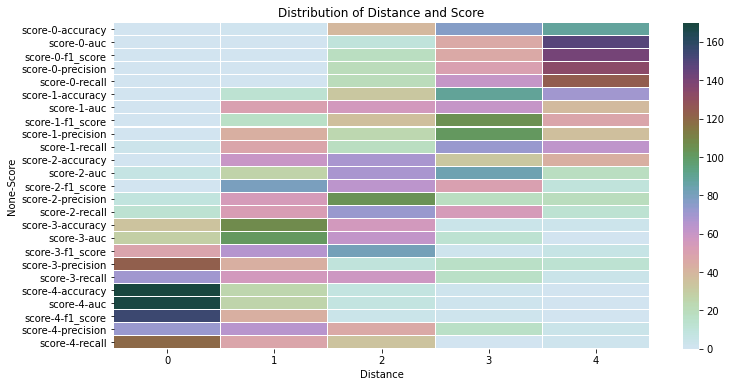

In [138]:
pt = df_dis.pivot_table(index='Distance', columns=['Score'] ,aggfunc=np.sum)
ax = show_heatmap(pt.T)
ax.set_title("Distribution of Distance and Score")
pt